In [ ]:
# https://stackoverflow.com/questions/48641189/fitting-3d-data-as-input-into-keras-sequential-model-layer

In [1]:
 #Use only CPU
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4123347089788451962
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9162099493350987648
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7650193066214775356
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31595870336
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17166724876986519771
physical_device_desc: "device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:00:06.0, compute capability: 7.0"
]


In [2]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve,auc
from keras.wrappers.scikit_learn import KerasClassifier
#keras
import keras
from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D
from tensorflow.python.keras.layers.recurrent import LSTM
# CuDNNLSTM error; The error was because from TensorFlow 2 you do not need to specify CuDNNLSTM. 
# You can just use LSTM with no activation function and it will automatically use the CuDNN version. You do have to install CuDNN first.

from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [25]:
import pickle5 as pickle
with open( "/home/ubuntu/data/AMPsNonAMPs_df.plk", 'rb') as file:
    AMPs_df = pickle.load(file)

In [26]:
AMPs_df.drop_duplicates(subset=['Sequence'],inplace=True)
AMPs_df

,ID,Sequence,length,class,reps
0,EN92515250|C|B3FJD7|phage 201phi2-1 lysin,MAKKSVPLRKPAGSDGQGNIKVPGGPVVLDLGDFDDIFGPMESESP...,2337,0,"[0.0032203220762312412, 0.07328620553016663, 0..."
1,EN54061055|C|F8SJ56|phage PhiPA3 lysin,MASKKTTLPKPKGINPQGSIVQLDLDDFDDLFDEDFGLPKKNSPYT...,2319,0,"[0.0027930964715778828, 0.06916013360023499, 0..."
2,EN4815120|C|Q8SCY1|phage phiKZ lysin,MAKKVTLPKGQTGATGTTLGQAGNILDLSDVDDIFGDTPKAKKGSP...,2237,0,"[0.0023172732908278704, 0.05406315624713898, 0..."
3,EN3016141|D|D2J8A7|bacteriocin,MAETIKGLRIDLSLKDMGVGRSITELKRSFRTLNSDLKVSSKNFEY...,1619,0,"[0.014644640497863293, 0.07187927514314651, 0...."
4,EN9175723|BD|Q93IM3|bacteriocin,MAKKKNTYKVPSIIALTLAGTALTTHHAQAADKTQDQSTNKNILND...,1564,0,"[0.0062357354909181595, 0.01848522014915943, 0..."
...,...,...,...,...,...
42439,UniRef50_B2ABU5 Podospora anserina S mat+ geno...,MKWKAIIAAYGM,12,1,"[0.04739842936396599, 0.01943567767739296, -0...."
42440,UniRef50_A0A151HEL5 Zinc finger C3HC4 type (R...,GLYFRPRRRASS,12,1,"[0.0483490452170372, -0.007824046537280083, -0..."
42441,UniRef50_K2MU79 Retrotransposon hot spot (RHS)...,MESNPMTLVGCG,12,1,"[0.047337695956230164, -0.013988062739372253, ..."
42442,UniRef50_A0A1E1IUT2 Flagellar calcium-binding ...,IRCVGHWMQAEH,12,1,"[0.04697670415043831, -0.027571065351366997, -..."


In [5]:
# AMPs_df = pd.read_pickle('AMPsNonAMPs_df.plk')
AMPs_df = pd.read_pickle('../datasets/AMPsNonAMPs_df.239.plk')
AMPs_df.drop_duplicates(subset=['Sequence'],inplace=True)
AMPs_df

,ID,Sequence,length,class,reps
2080,L01A002211|Sequence 1225 from patent US 6573361,MANTKSAIKRIKTIERNRIRNCAYKSVVKTFIKKYLKVLSDYTNAP...,95,0,"[0.006758428644388914, -0.010547993704676628, ..."
2112,ADAM_0164|adam_test,AISYDQVKSSLLPCVGYVRGNNARPAPPNYCKGIRSLKSAARIRLD...,94,0,"[0.009842261672019958, -0.09050261229276657, 0..."
2223,ADAM_4403|adam_test,MKYCVVILALLVALVCITESRSTETGYAVAETLEDNDLDELQAYLE...,93,0,"[0.005940052680671215, -0.01924821361899376, 0..."
2232,ADAM_6138|adam_test,VGSEVSDKRTCVSLTTQRLPVSRIKTYTITEGSLRAVIFITKRGLK...,93,0,"[0.010578776709735394, -0.05168537050485611, 0..."
2315,L01A002317|Sequence 1515 from patent US 6573361,MGRSLKKGPFVAASLLRKIDKLNDKGDKQVVKTWSRASTILPQMVG...,92,0,"[0.004393417853862047, -0.061859458684921265, ..."
...,...,...,...,...,...
41948,UniRef50_A0A2H3S7M8 Uncharacterized protein n=...,MPLAYCSYSYN,11,1,"[0.05190926417708397, 0.029500924050807953, -0..."
41950,UniRef50_A0A2H3SG47 Uncharacterized protein n=...,MASQYGWLNSL,11,1,"[0.05131299048662186, -0.013223196379840374, -..."
42034,UniRef50_A0A0G4N8C6 Uncharacterized protein (F...,ARECSQGGSRP,11,1,"[0.05259896442294121, -0.022827953100204468, -..."
42146,UniRef50_A2NU82 Myeloperoxidase n=1 Tax=Homo s...,MTAAGKGIREQ,11,1,"[0.05165543779730797, -0.025750694796442986, -..."


### Utility function: plot_history, display_model_score

In [6]:
def plot_history(history):
  # dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# Display model score(Loss & Accuracy) across all sets.
def display_model_score(model, train, val, test):
  train_score = model.evaluate(train[0], train[1], verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)
  val_score = model.evaluate(val[0], val[1], verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  test_score = model.evaluate(test[0], test[1], verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

def plot_history_CV(cv, estimator,x,y):
  # plot arrows
  fig1 = plt.figure(figsize=[12,12])
  ax1 = fig1.add_subplot(111,aspect = 'equal')
  ax1.add_patch(
      patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
      )
  ax1.add_patch(
      patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
      )

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0,1,100)
  i = 1
  for train,test in cv.split(x,y):
      model = create_Modelbaseline()
      model.fit(x[train],y.iloc[train],
            epochs=30,
            shuffle=True,verbose=0)
      prediction = model.predict(x[test])
      fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
      tprs.append(interp(mean_fpr, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs.append(roc_auc)
      plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
      i= i+1

  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  plt.plot(mean_fpr, mean_tpr, color='blue',
          label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
  plt.show()

# Split Train/ Test / Validation set

In [27]:
X= np.array(AMPs_df['reps'].to_list())
y= np.array(AMPs_df['class'].to_list())

In [28]:
input_shape  = X.shape
input_shape 

(41951, 1900)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [30]:
# Given data size
print('Train size: ', len(X_train))
print('Val size: ', len(X_val))
print('Test size: ', len(X_test))

Train size:  25170
Val size:  8390
Test size:  8391


# Model 4: CNN simple model 

In [ ]:
# 3d dimension
# Batchs, n_timesteps, n_features

# Images 3d dimension
# width , heigth , channel

In [31]:
import numpy as np
# https://stackoverflow.com/questions/52803989/how-to-correct-shape-of-keras-input-into-a-3d-array/52804200
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

(25170, 1900, 1)
(8391, 1900, 1)
(8390, 1900, 1)


In [32]:
X_train[0][0]

array([0.01734208])

In [38]:
# n_timesteps, n_features, n_outputs = X_train.shape[2], X_train.shape[1], 1
tf.keras.backend.clear_session()
def create_Modelbaseline():
    x_input = Input(shape=(1900,1)) # n_timesteps, n_features
    # Conv
    conv = Conv1D(1024, kernel_size=1, padding='same', activation='relu')(x_input) 
    conv = MaxPooling1D(pool_size=3)(conv)
    conv = Conv1D(512, kernel_size=1, padding='same', activation='relu')(conv) 
    conv = MaxPooling1D(pool_size=3)(conv)
    conv = Conv1D(256, kernel_size=1, padding='same', activation='relu')(conv) 
    conv = MaxPooling1D(pool_size=3)(conv)
    # Flatten NN
    flat = Flatten()(conv)
    layer_3 = Dense(128)(flat)
    dropout_3 = Dropout(0.2)(layer_3)
    layer_4 = Dense(64)(dropout_3)
    dropout_4 = Dropout(0.2)(layer_4)
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l2(0.0001))(dropout_4)

    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_Modelbaseline()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1900, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1900, 1024)        2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 633, 1024)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 633, 512)          524800    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 211, 512)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 211, 256)          131328    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 70, 256)          

In [39]:
checkpoint = ModelCheckpoint("ourCNN.bestmodel.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val),
                     callbacks=[checkpoint,es], verbose=1)

Epoch 1/100
394/394 [==============================] - ETA: 0s - loss: 0.3883 - accuracy: 0.8203
Epoch 00001: loss improved from inf to 0.38832, saving model to ourCNN.bestmodel.hdf5
394/394 [==============================] - 17s 44ms/step - loss: 0.3883 - accuracy: 0.8203 - val_loss: 0.3469 - val_accuracy: 0.8392
Epoch 2/100
394/394 [==============================] - ETA: 0s - loss: 0.3360 - accuracy: 0.8517
Epoch 00002: loss improved from 0.38832 to 0.33603, saving model to ourCNN.bestmodel.hdf5
394/394 [==============================] - 17s 43ms/step - loss: 0.3360 - accuracy: 0.8517 - val_loss: 0.3471 - val_accuracy: 0.8523
Epoch 3/100
393/394 [============================>.] - ETA: 0s - loss: 0.3129 - accuracy: 0.8631
Epoch 00003: loss improved from 0.33603 to 0.31281, saving model to ourCNN.bestmodel.hdf5
394/394 [==============================] - 17s 43ms/step - loss: 0.3128 - accuracy: 0.8632 - val_loss: 0.3427 - val_accuracy: 0.8560
Epoch 4/100
394/394 [=======================

In [36]:
display_model_score(model,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

787/787 [==============================] - 4s 5ms/step - loss: 0.2537 - accuracy: 0.8862
Train loss:  0.2537158131599426
Train accuracy:  0.8862137198448181
----------------------------------------------------------------------
263/263 [==============================] - 1s 5ms/step - loss: 0.2825 - accuracy: 0.8722
Val loss:  0.2825438976287842
Val accuracy:  0.8722288608551025
----------------------------------------------------------------------
263/263 [==============================] - 1s 5ms/step - loss: 0.2739 - accuracy: 0.8755
Test loss:  0.27394112944602966
Test accuracy:  0.8754618167877197


In [37]:
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4264
           1       0.94      0.80      0.86      4127

    accuracy                           0.88      8391
   macro avg       0.88      0.87      0.87      8391
weighted avg       0.88      0.88      0.87      8391



## MEmbedding

In [28]:

word_input=Input(shape=(input_shape),dtype='float64')  

# creating the embedding
word_embedding=Embedding(input_dim=24,output_dim=1900,input_length=1900)(word_input)

word_vec=Flatten()(word_embedding) # flatten
embed_model =Model([word_input],word_vec) # combining all into a Keras model
embed_model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),loss='binary_crossentropy',metrics=['acc']) 
# compiling the model. parameters can be tuned as always.
print(embed_model.summary()) # summary of the model

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 239, 1900)]       0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 239, 1900, 1900)   45600     
_________________________________________________________________
flatten_3 (Flatten)          (None, 862790000)         0         
Total params: 45,600
Trainable params: 45,600
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
embeddings=embed_model.predict(X_train[0]) # finally getting the embeddings.

In [30]:
X_train[0]

array([ 0.01733692, -0.0335286 ,  0.01197986, ...,  0.05971117,
        0.06566247, -0.02294011])

In [31]:
print(embeddings)

[[ 0.02140281  0.0160512  -0.01652263 ... -0.01446537 -0.03235978
   0.00240989]
 [ 0.02140281  0.0160512  -0.01652263 ... -0.01446537 -0.03235978
   0.00240989]
 [ 0.02140281  0.0160512  -0.01652263 ... -0.01446537 -0.03235978
   0.00240989]
 ...
 [ 0.02140281  0.0160512  -0.01652263 ... -0.01446537 -0.03235978
   0.00240989]
 [ 0.02140281  0.0160512  -0.01652263 ... -0.01446537 -0.03235978
   0.00240989]
 [ 0.02140281  0.0160512  -0.01652263 ... -0.01446537 -0.03235978
   0.00240989]]


In [32]:
len(embeddings)

1900

In [33]:
embeddings.shape

(1900, 1900)

In [109]:
import numpy as np
# https://stackoverflow.com/questions/52803989/how-to-correct-shape-of-keras-input-into-a-3d-array/52804200
X_train = np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],1,X_val.shape[1]))
print(X_val.shape)

(143, 1, 1900)
(48, 1, 1900)
(48, 1, 1900)


In [116]:
X_test[0]

array([[ 0.04603789, -0.07072274, -0.03860193, ..., -0.01830798,
         0.05091501,  0.05827223]])

# Model 3: ProtCNN
https://www.biorxiv.org/content/10.1101/626507v3.full

In [40]:
def residual_block(data, filters, d_rate):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """

  shortcut = data

  bn1 = BatchNormalization()(data)
  act1 = Activation('relu')(bn1)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

  #bottleneck convolution
  bn2 = BatchNormalization()(conv1)
  act2 = Activation('relu')(bn2)
  conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

  #skip connection
  x = Add()([conv2, shortcut])

  return x

In [50]:
# model

x_input = Input(shape=(1900,1))

#initial conv
conv = Conv1D(256, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 256, 2)
res2 = residual_block(res1, 256, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
layer_4 = Dense(128 , activation='relu')(x)
x_output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))(layer_4)

model_ProtCNN = Model(inputs=x_input, outputs=x_output)
model_ProtCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_ProtCNN.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1900, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 1900, 256)    512         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 1900, 256)    1024        conv1d_32[0][0]                  
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 1900, 256)    0           batch_normalization_22[0][0]     
______________________________________________________________________________________

In [52]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint = ModelCheckpoint("ProtCNN.bestmodel.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)
history2 = model_ProtCNN.fit(
    X_train, y_train,
    epochs=100, batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[es,checkpoint]
    )


Epoch 1/50
394/394 [==============================] - ETA: 0s - loss: 2.0282 - accuracy: 0.8286
Epoch 00001: loss improved from inf to 2.02816, saving model to ProtCNN.bestmodel.hdf5
394/394 [==============================] - 36s 91ms/step - loss: 2.0282 - accuracy: 0.8286 - val_loss: 3.6051 - val_accuracy: 0.5079
Epoch 2/50
393/394 [============================>.] - ETA: 0s - loss: 1.1019 - accuracy: 0.8775
Epoch 00002: loss improved from 2.02816 to 1.10186, saving model to ProtCNN.bestmodel.hdf5
394/394 [==============================] - 35s 90ms/step - loss: 1.1019 - accuracy: 0.8775 - val_loss: 1.0693 - val_accuracy: 0.8503
Epoch 3/50
393/394 [============================>.] - ETA: 0s - loss: 0.9265 - accuracy: 0.8912
Epoch 00003: loss improved from 1.10186 to 0.92654, saving model to ProtCNN.bestmodel.hdf5
394/394 [==============================] - 35s 89ms/step - loss: 0.9265 - accuracy: 0.8912 - val_loss: 0.8702 - val_accuracy: 0.8853
Epoch 4/50
393/394 [========================

In [53]:
y_probas = model_ProtCNN.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      4264
           1       0.87      0.94      0.91      4127

    accuracy                           0.90      8391
   macro avg       0.91      0.90      0.90      8391
weighted avg       0.91      0.90      0.90      8391



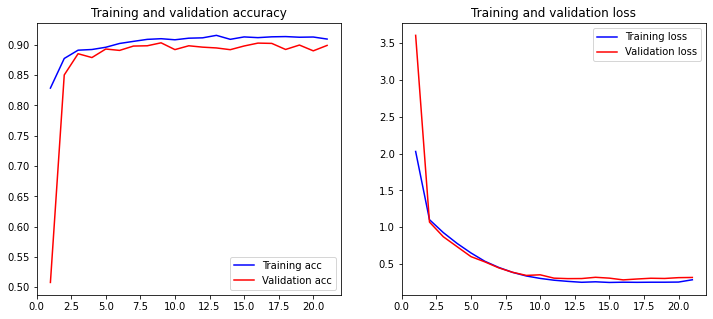

In [54]:
plot_history(history2)

In [55]:
display_model_score(model_ProtCNN,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

787/787 [==============================] - 11s 14ms/step - loss: 0.2503 - accuracy: 0.9197
Train loss:  0.25034141540527344
Train accuracy:  0.9197457432746887
----------------------------------------------------------------------
263/263 [==============================] - 4s 14ms/step - loss: 0.3172 - accuracy: 0.8990
Val loss:  0.31718045473098755
Val accuracy:  0.8990464806556702
----------------------------------------------------------------------
263/263 [==============================] - 4s 14ms/step - loss: 0.3027 - accuracy: 0.9032
Test loss:  0.3027271330356598
Test accuracy:  0.9032296538352966


# Conclusion